In [1]:
%matplotlib inline
import csv
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np

from integrate import calc_efficiency2 as calc_efficiency

from scipy import stats
import ast
from collections import OrderedDict



def read_records(filename):
    data = open(filename, 'r').read()
    records = list(csv.DictReader(data.splitlines()))
    return records

def read_params(filename):
    params = open('{}.params'.format(filename), 'r').read()
    all_params = list(csv.DictReader(params.splitlines()))
    return all_params

def parse_id(id):
    attack = id.split('(')[0]
    params = ast.literal_eval(id.split('(')[1][:-1])
    attackers, victims, depth, size = params
    return {'attack': str(attack),
            'attackers': list(attackers),
            'victim': expand_host(victims),
            'depth': int(depth),
            'size': float(size)}

def new_efficiency(p, r, alpha_override=None, beta_override=None):
#    print(p.keys())
#    print(r.keys())
# p odict_keys(['id', 'alliance', 'success', 'size', 'victims', 'delay', 'level', 'approach', 
#               'behaviour', 'fixed', 'timeout', 'budget', 'attackers', 'defense', 'repeat', 
#               'costs', 'ap3_recovery_waittime', 'nodes', 'attack', 'periodic', 
#               'source', 'oid', 'depth'])

# r odict_keys(['id', 'timeout', 'init', 'start', 'detect', 'recover', 'end', 'settings', 
#               'approach', 'thresholds', 'costs', 'values', 'impacts', 'total_cost', 
#               'budget_spent', 'efficiency', 'source', 'oid'])

    attack = p['attack']
    weights = ast.literal_eval(r['settings'])['weights']
    impacts = ast.literal_eval(r['impacts'])[expand_host('service101')]
    for w in weights[attack].keys():
        if w not in impacts.keys():
            impacts[w] = np.nan
    
    thresh = ast.literal_eval(r['thresholds'])[expand_host('service101')]
    negates = {k: False if i =='sales' else True for k, i in impacts.items()}
    timeout = int(p['timeout'])
    total_cost = int(r['total_cost'])
    budget = int(p['budget'])
    recovered = bool(r['recover']) 
    alpha = ast.literal_eval(r['settings'])['alpha']
    if alpha_override:
        alpha = alpha_override
    beta = ast.literal_eval(r['settings'])['beta']
    if beta_override:
        beta = beta_override
        
    efficiency = calc_efficiency(attack, impacts, weights[attack], 
                    thresh, negates, timeout, total_cost,
                    budget, recovered, alpha, beta)
    return efficiency

def expand_host(host):
    return "service101.as101.sarnet-sc17-dev"


def prep_df(records, all_params=None, victim='service101.as101.sarnet-sc17-dev'):
    effl = []
    p = None
    for r in records:
        p = [param for param in all_params if int(param['id']) == int(r['id'])]
        assert 0 < len(p) < 2
        if len(p) == 0:
            continue
        p = p[0]
        assert p['oid'] == r['oid']
        p['depth'] = p['level']
        efficiency2 = new_efficiency(p, r)
        efficiency_check = -1
        with warnings.catch_warnings(): 
            warnings.simplefilter("ignore")
            efficiency_check = new_efficiency(p, r, alpha_override=1)
        params = {
            'attack': p['attack'],
            'approach': int(r['approach']),
            'size': p['size'],
            'level': p['depth'],
            'efficiency': float(ast.literal_eval(r['efficiency'])[victim]),
            'efficiency2': efficiency2,
            'recover': r['recover'],
            'detect': r['detect'],
            'cost': int(ast.literal_eval(r['total_cost'])),
            'waittime': 3,
            #'waittime': int(p['ap3_recovery_waittime']),
            'fixed': int(p['fixed']),
            'budget': int(p['budget']),
            'attackers': ','.join([a.split('.')[0] for a in ast.literal_eval(p['attackers'])]),
            'oid': ','.join([r['id'], p['id']])
        }
        assert params['efficiency'] == efficiency_check, 'efficiency not equal'
        params['efficiency'] = params['efficiency2']
        ip = ast.literal_eval(r['impacts'])[victim].get('sales')
        try:
            params['impact'] = float(ip)
        except:
            import numpy as np
            params['impact'] = np.nan
        effl.append(params)

    #pprint.pprint(effl)
    df = pd.DataFrame(list(effl), columns=[
        'attack',
        'approach',
        'size',
        'level',
        'efficiency',
        'efficiency2',
        'recover',
        'detect',
        'cost',
        'impact',
        'waittime',
        'fixed',
        'attackers',
        'budget',
        'oid'
    ] )
    df['efficiency'] = df['efficiency'].replace(-1, 0)
    return df

def megaplot2(df, axis, plot_sep=None):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.scatterplot(x=axis[0], y=axis[1], style=plot_sep, data=df, palette='muted')
    ax.legend(loc=5)
    
def megaplot3(df, axis, plot_sep=None):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    df_all = df
    df_grouped = df_all.groupby(["situation", plot_sep, axis[0]])
    df = df_grouped.mean()
    df["STDEV"] = df_grouped.efficiency.apply(statistics.stdev)
    df["SEM"] = df_grouped.efficiency.apply(stats.sem)
 
    #stats.t.ppf(1-0.025, 2) #len-1
    df["CI"] = df_grouped.efficiency.apply(stats.sem) * 1.96
    #print((df_grouped.efficiency))
    df["CI"] = df_grouped.efficiency.apply(stats.sem) * stats.t.ppf(1-0.025, 2) #len-1
    df.reset_index(inplace=True)
    #df['marker'] = df['approach'].map(markers)
    xticks=sorted(list(set(df[axis[0]])))
    print(xticks)
    
    g = sns.FacetGrid(df, col='situation', 
                      hue='approach', 
                      palette='muted', 
                      col_wrap=2,
                      hue_kws=dict(marker=['o', '^', 'v']))
    g.map(plt.errorbar, axis[0], axis[1], "STDEV", fmt='.').set_titles('{col_name}').set(xticks=xticks)
    for ax in g.axes.flat:
        ax.set_title(fullsit(ax.get_title()))
        if ax.get_xlabel() == 'size':
            ax.set_xlabel('attack size')
            ax.set_xticklabels(xticks, rotation=40, ha="center")
            ax.set_xticklabels(xticks, fontsize=8)
        elif ax.get_xlabel() == 'level':
            ax.set_xlabel('alliance size')
        
    g.add_legend(title='Algorithm')


def megaplot(df, axis, plot_sep=None):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    def doplot(df, subplot=None):
        ax = sns.barplot(x=axis[0],
                         y=axis[1],
                         data=df,
                         palette='muted',
                         ax=subplot
                         )
        # ax.legend(loc=5)

    if plot_sep:
        categories = df[plot_sep].unique()
        f, axarr = plt.subplots(1, len(categories), sharex=True)
        for subplot, category in zip(axarr, categories):
            dft = df[df[plot_sep] == category]
            doplot(dft, subplot)
            subplot.set_ylim(df[axis[1]].min()-df[axis[1]].max()/10, df[axis[1]].max())
            if isinstance(category,str):
                try:
                    float(category)
                    subplot.set_title(category)
                except:
                    subplot.set_title(category.split('.')[0])
            else:
                subplot.set_title(category)

    else:
        doplot(df, None)



# %%
#data = open('data/heavyness3', 'r').read()

#filename = 'data/topo3/levelap123'
#filename = 'data/topo3/dynap3beta'

def read_all(f_list, params=False):
    def reorder(r, order):
        newdict = OrderedDict([(k, None) for k in order if k in r])
        newdict.update(r)
        return newdict

    all_records = []
    orderr = None
    offset = 0
    for filename in f_list:
        if params: 
            records = read_params(filename)
        else:
            records = read_records(filename)
        counter = offset
        for counter, r in enumerate(records):
            if not orderr:
                orderr = list(r.keys())
            else:
                r = reorder(r, orderr)
            r['source'] = filename
            r['oid'] = r['id']
            r['id'] = str(counter + offset)
            all_records.append(r)
        offset = offset + len(records)
    return all_records

from collections import namedtuple
Plot = namedtuple('Plot', ['name', 'x', 'y', 'sep'])
attacks = ['eq2attackerfarnear', 'fixedcosts', 'increaselevel',  'moveattacker']




In [2]:
scenarios = [
        Plot('budget', 'budget', 'efficiency', 'approach'),
        Plot('load', 'size', 'efficiency', 'approach'),
        Plot('size', 'level', 'efficiency', 'approach'),
]

#scenarios = [
#        Plot('budget', 'budget', 'impact', 'approach'),
#        Plot('load', 'size', 'impact', 'approach'),
#        Plot('size', 'level', 'impact', 'approach'),
#]

situations = ['1n', '1f', '2s', 'al']

def fullsit(situation):
    fullsit = {'1n': 'single attacker close', 
               '1f': 'single attacker far', 
               '2s': 'two attackers 1 far 1 close', 
               'al': 'all clients attacking'}
    return fullsit[situation]


def build_df(func):
    def wrapper(scenario, situation):
        f_list = func(scenario, situation)
        records = read_all(f_list)
        params = read_all(f_list, params=True)
        df = prep_df(records, params)
        return df
    return wrapper

def build_mdf(func, modify_func=None):
    dfs = [func(scenario, situation) for situation in situations]
    mdf = pd.concat(dfs, keys=situations, names=['situation']) 
    mdf = mdf.reset_index(level=0)
    if modify_func:
        mdf = modify_func(mdf)
    return mdf 
    

# Efficiency vs Budget

[300, 600, 900]


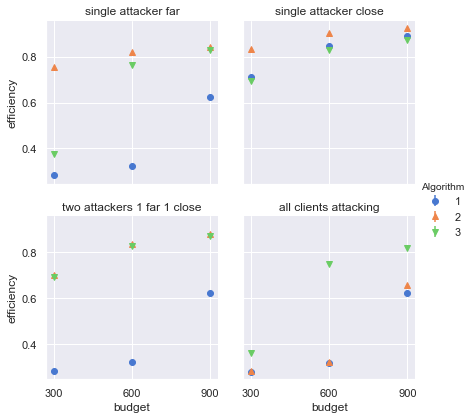

In [3]:
@build_df
def line_df(scenario, situation):
    f_list = ['runall{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    if situation == 'al':
        f_list = ['runall{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['3']]
    return f_list

@build_df
def tree_df(scenario, situation):
    f_list = ['tree1{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    return f_list

scenario = 0
mdf = build_mdf(line_df)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear

plt.savefig('budget.eps', format='eps', dpi=1000)


[300, 600, 900]


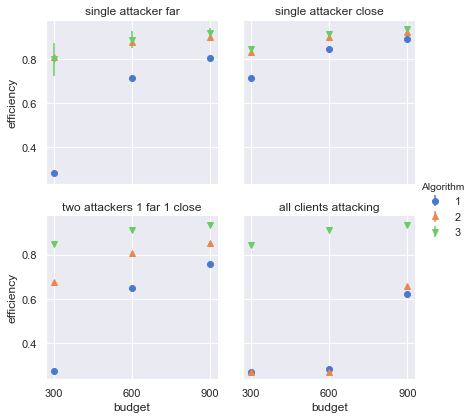

In [4]:
scenario = 0
mdf = build_mdf(tree_df)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear
plt.savefig('budget-tree.eps', format='eps', dpi=1000)

# Efficiency vs Attack Size

[0.3, 0.4, 0.5, 0.6, 0.9, 1.5, 2.0]


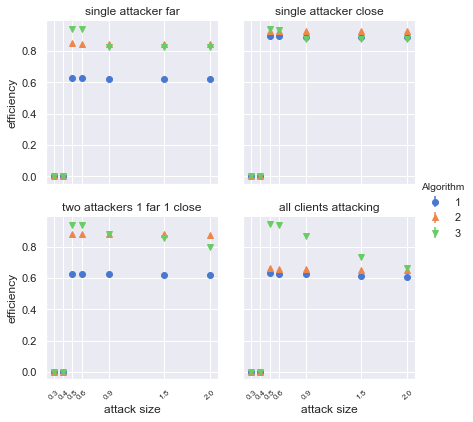

In [5]:
@build_df
def line_df(scenario, situation):
    f_list = ['runall{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['', '2']]
    f_list2 = ['heavyload{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    f_list2 = ['line3{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    f_list = f_list + f_list2
    return f_list

@build_df
def tree_df(scenario, situation):
    f_list = ['tree1{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    f_list2 = ['tree2{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    f_list = f_list+ f_list2
    return f_list

def reconstruct_size(mdf):
    mdf['num_attackers'] = mdf['attackers'].apply(lambda x: len(x.split(',')))
    mdf['totalsize'] = mdf['size'].astype(float) * mdf['num_attackers'].astype(float)
    mdf['size'] = mdf['totalsize'].apply(lambda x: round(float(x), 1))
    mdf = mdf.reset_index(level=0)
    return mdf

scenario = 1
mdf = build_mdf(line_df, reconstruct_size)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear

plt.savefig('attacksize.eps', format='eps', dpi=1000)

[0.3, 0.4, 0.5, 0.6, 0.9, 1.5, 2.0]


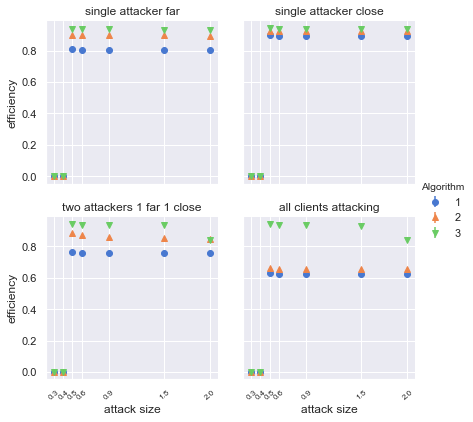

In [6]:
scenario = 1
mdf = build_mdf(tree_df, reconstruct_size)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear
plt.savefig('attacksize-tree.eps', format='eps', dpi=1000)

## Efficiency vs Size zoomed (without failed to detect)

index situation attack  approach  size level  efficiency  efficiency2  \
9        9        1n   ddos         1   0.6     8    0.891544     0.891544   
10      10        1n   ddos         1   0.6     8    0.892219     0.892219   
11      11        1n   ddos         1   0.6     8    0.892603     0.892603   
12      12        1n   ddos         2   0.6     8    0.923300     0.923300   
13      13        1n   ddos         2   0.6     8    0.923710     0.923710   
14      14        1n   ddos         2   0.6     8    0.924409     0.924409   
15      15        1n   ddos         3   0.6     8    0.937087     0.937087   
16      16        1n   ddos         3   0.6     8    0.935601     0.935601   
17      17        1n   ddos         3   0.6     8    0.936018     0.936018   
18      18        1n   ddos         1   0.9     8    0.890250     0.890250   
19      19        1n   ddos         1   0.9     8    0.890173     0.890173   
20      20        1n   ddos         1   0.9     8    0.889410     0.889410   
21      21        1n   ddos         2   0.9     8    0.924203     0.924203   
22      22        1n   ddos         2   0.9     8    0.924810     0.924810   
23      23        1n   ddos         2   0.9     8    0.923667     0.923667   
24      24        1n   ddos         3   0.9     8    0.874237     0.874237   
25      25        1n   ddos         3   0.9     8    0.872833     0.872833   
26      26        1n   ddos         3   0.9     8    0.873518     0.873518   
36      36        1n   ddos         1   0.5     8    0.894398     0.894398   
37      37        1n   ddos         1   0.5     8    0.897663     0.897663   
38      38        1n   ddos         1   0.5     8    0.896034     0.896034   
39      39        1n   ddos         2   0.5     8    0.927531     0.927531   
40      40        1n   ddos         2   0.5     8    0.927803     0.927803   
41      41        1n   ddos         2   0.5     8    0.928003     0.928003   
42      42        1n   ddos         3   0.5     8    0.942029     0.942029   
43      43        1n   ddos         3   0.5     8    0.938638     0.938638   
44      44        1n   ddos         3   0.5     8    0.941164     0.941164   
45      45        1n   ddos         1   1.5     8    0.891192     0.891192   
46      46        1n   ddos         1   1.5     8    0.889165     0.889165   
47      47        1n   ddos         1   1.5     8    0.890431     0.890431   
..     ...       ...    ...       ...   ...   ...         ...          ...   
213     24        al   ddos         3   0.9     8    0.850184     0.850184   
214     25        al   ddos         3   0.9     8    0.879864     0.879864   
215     26        al   ddos         3   0.9     8    0.881530     0.881530   
225     36        al   ddos         1   0.5     8    0.630891     0.630891   
226     37        al   ddos         1   0.5     8    0.630982     0.630982   
227     38        al   ddos         1   0.5     8    0.630734     0.630734   
228     39        al   ddos         2   0.5     8    0.662863     0.662863   
229     40        al   ddos         2   0.5     8    0.663521     0.663521   
230     41        al   ddos         2   0.5     8    0.665510     0.665510   
231     42        al   ddos         3   0.5     8    0.940681     0.940681   
232     43        al   ddos         3   0.5     8    0.942493     0.942493   
233     44        al   ddos         3   0.5     8    0.944032     0.944032   
234     45        al   ddos         1   1.5     8    0.612551     0.612551   
235     46        al   ddos         1   1.5     8    0.614284     0.614284   
236     47        al   ddos         1   1.5     8    0.615076     0.615076   
237     48        al   ddos         1   2.0     8    0.607137     0.607137   
238     49        al   ddos         1   2.0     8    0.607047     0.607047   
239     50        al   ddos         1   2.0     8    0.608295     0.608295   
240     51        al   ddos         2   1.5     8    0.655613     0.655613   
241     52        al   ddos

[0.5, 0.6, 0.9, 1.5, 2.0]


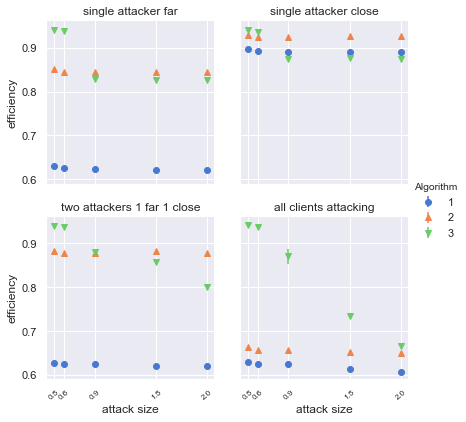

In [7]:
scenario = 1
mdf = build_mdf(line_df, reconstruct_size)
mdf = mdf[mdf['size'] > .4]
display(mdf)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear

plt.savefig('attacksize-zoomed.eps', format='eps', dpi=1000)

[0.5, 0.6, 0.9, 1.5, 2.0]


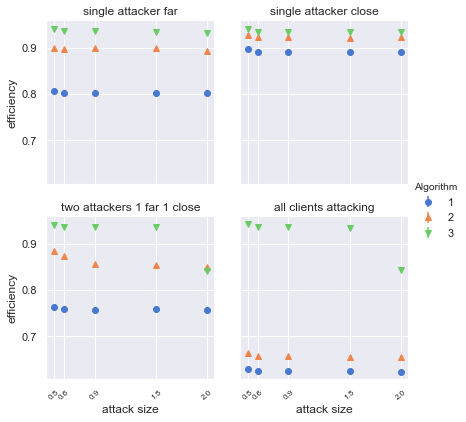

In [8]:
scenario = 1
mdf = build_mdf(tree_df, reconstruct_size)
mdf = mdf[mdf['size'] >= .5]
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear

plt.savefig('attacksize-zoomed-tree.eps', format='eps', dpi=1000)


# Efficiency vs Alliance Size

['4', '6', '8']


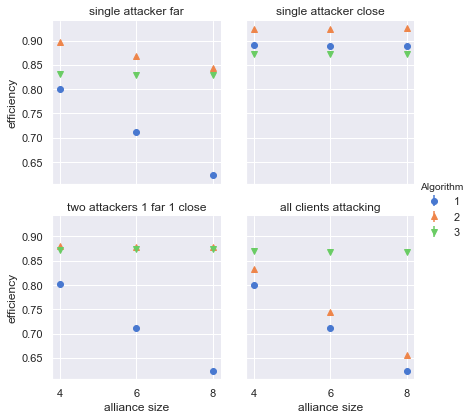

In [9]:
@build_df
def tree_df(scenario, situation):
    f_list = ['tree1{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    f_list2 = ['tree2{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    if situation == '2s':
        f_list3 = ['tree3{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
        f_list = f_list3 + f_list + f_list2
    else:
        f_list = f_list + f_list2
    return f_list

@build_df
def line_df(scenario, situation):
    f_list = ['runall{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['']]
    if situation == '2s':
        f_list = ['runall{}{}{}'.format(num, scenarios[scenario].name, situation) for num in ['2']]
    return f_list

scenario = 2
mdf = build_mdf(line_df)
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear

plt.savefig('alliancesize.eps', format='eps', dpi=1000)


[1, 2, 3, 4]


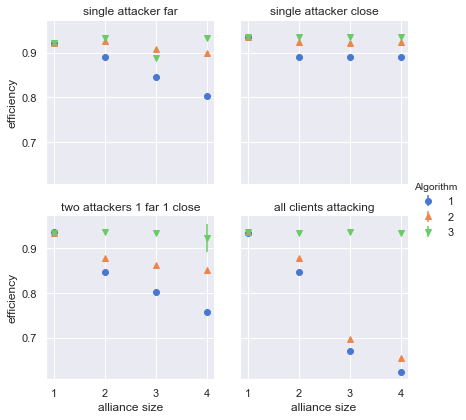

In [10]:
scenario = 2
mdf = build_mdf(tree_df)
mdf['level'] = pd.to_numeric(mdf['level'])
megaplot3(mdf, [scenarios[scenario].x, scenarios[scenario].y], plot_sep=scenarios[scenario].sep) #eq2attackerfarnear
plt.savefig('alliancesize-tree.eps', format='eps', dpi=1000)